# Название проекта:
Выпускной проект: телекомуникация

# Цель:
Разработать модель, которая будет прогнозировать отток клиентов.

# Исходные данные:
4 датасета: в 1 - информация о договоре, во 2 - персональные данные клиента, в 3 - информация об интернет-услугах, в 4 - информация об услугах телефонии.

# Описание проекта:
Оператор связи «ТелеДом» хочет бороться с оттоком клиентов. Для этого его сотрудники начнут предлагать промокоды и специальные условия всем, кто планирует отказаться от услуг связи. Чтобы заранее находить таких пользователей, «ТелеДому» нужна модель, которая будет предсказывать, разорвёт ли абонент договор.

# План:
- Загрузка данных
- Исследовательский анализ и предобработка данных
- Объединение данных
- Исследовательский анализ и предобработка данных объединённого датафрейма
- Подготовка данных
- Обучение моделей
- Выбор лучшей модели
- Оформление вывода

## Загрузка данных

In [1]:
!pip3 install -q phik

In [2]:
pip install -q --upgrade scikit-learn

Note: you may need to restart the kernel to use updated packages.


In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
import re

from sklearn.model_selection import train_test_split, RandomizedSearchCV, cross_val_score
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, StandardScaler, MinMaxScaler
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.pipeline import Pipeline
from catboost import CatBoostClassifier
from sklearn.metrics import roc_auc_score, roc_curve, auc


import phik

In [4]:
RANDOM_STATE = 141024
TEST_SIZE = 0.25

In [5]:
pth1 = 'https://code.s3.yandex.net/datasets/contract_new.csv'
pth2 = 'https://code.s3.yandex.net/datasets/personal_new.csv'
pth3 = 'https://code.s3.yandex.net/datasets/internet_new.csv'
pth4 = 'https://code.s3.yandex.net/datasets/phone_new.csv'

data_contract = pd.read_csv(pth1,parse_dates=['BeginDate', 'EndDate'])
data_personal = pd.read_csv(pth2)
data_internet = pd.read_csv(pth3)
data_phone = pd.read_csv(pth4)

In [6]:
data_contract.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 8 columns):
 #   Column            Non-Null Count  Dtype         
---  ------            --------------  -----         
 0   customerID        7043 non-null   object        
 1   BeginDate         7043 non-null   datetime64[ns]
 2   EndDate           7043 non-null   object        
 3   Type              7043 non-null   object        
 4   PaperlessBilling  7043 non-null   object        
 5   PaymentMethod     7043 non-null   object        
 6   MonthlyCharges    7043 non-null   float64       
 7   TotalCharges      7043 non-null   object        
dtypes: datetime64[ns](1), float64(1), object(6)
memory usage: 440.3+ KB


In [7]:
data_contract.head()

,customerID,BeginDate,EndDate,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges
0,7590-VHVEG,2020-01-01,No,Month-to-month,Yes,Electronic check,29.85,31.04
1,5575-GNVDE,2017-04-01,No,One year,No,Mailed check,56.95,2071.84
2,3668-QPYBK,2019-10-01,No,Month-to-month,Yes,Mailed check,53.85,226.17
3,7795-CFOCW,2016-05-01,No,One year,No,Bank transfer (automatic),42.30,1960.6
4,9237-HQITU,2019-09-01,No,Month-to-month,Yes,Electronic check,70.70,353.5


In [8]:
data_personal.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 5 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   customerID     7043 non-null   object
 1   gender         7043 non-null   object
 2   SeniorCitizen  7043 non-null   int64 
 3   Partner        7043 non-null   object
 4   Dependents     7043 non-null   object
dtypes: int64(1), object(4)
memory usage: 275.2+ KB


In [9]:
data_personal.head()

,customerID,gender,SeniorCitizen,Partner,Dependents
0,7590-VHVEG,Female,0,Yes,No
1,5575-GNVDE,Male,0,No,No
2,3668-QPYBK,Male,0,No,No
3,7795-CFOCW,Male,0,No,No
4,9237-HQITU,Female,0,No,No


In [10]:
data_internet.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5517 entries, 0 to 5516
Data columns (total 8 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   customerID        5517 non-null   object
 1   InternetService   5517 non-null   object
 2   OnlineSecurity    5517 non-null   object
 3   OnlineBackup      5517 non-null   object
 4   DeviceProtection  5517 non-null   object
 5   TechSupport       5517 non-null   object
 6   StreamingTV       5517 non-null   object
 7   StreamingMovies   5517 non-null   object
dtypes: object(8)
memory usage: 344.9+ KB


In [11]:
data_internet.head()

,customerID,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies
0,7590-VHVEG,DSL,No,Yes,No,No,No,No
1,5575-GNVDE,DSL,Yes,No,Yes,No,No,No
2,3668-QPYBK,DSL,Yes,Yes,No,No,No,No
3,7795-CFOCW,DSL,Yes,No,Yes,Yes,No,No
4,9237-HQITU,Fiber optic,No,No,No,No,No,No


In [12]:
data_phone.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6361 entries, 0 to 6360
Data columns (total 2 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   customerID     6361 non-null   object
 1   MultipleLines  6361 non-null   object
dtypes: object(2)
memory usage: 99.5+ KB


In [13]:
data_phone.head()

,customerID,MultipleLines
0,5575-GNVDE,No
1,3668-QPYBK,No
2,9237-HQITU,No
3,9305-CDSKC,Yes
4,1452-KIOVK,Yes


In [14]:
#Приведем названия столбцов к змеиному регистру и заменим customerID на id
for data in [data_contract, data_personal, data_internet, data_phone]:
    data.rename(columns={'customerID':'id'}, inplace=True)
    data.columns = [re.sub(r'(?<!^)(?=[A-Z])', '_', i).lower() for i in data.columns]

Данные соотвествуют описанию задачи. В первом датафрейме - 7043 оъектов, во втором - 7043, в третьем - 5517, в четвертом -6361. Все названия столбцов приведены к змеиному регистру.

## Исследовательский анализ и предобработка данных

Проверим наличие пропусков в данных

In [15]:
print(f'Пропусков в data_contract: {data_contract.isnull().sum()}')
print()
print(f'Пропусков в data_personal: {data_personal.isnull().sum()}')
print()
print(f'Пропусков в data_internet: {data_internet.isnull().sum()}')
print()
print(f'Пропусков в data_phone: {data_phone.isnull().sum()}')

Пропусков в data_contract: id                   0
begin_date           0
end_date             0
type                 0
paperless_billing    0
payment_method       0
monthly_charges      0
total_charges        0
dtype: int64

Пропусков в data_personal: id                0
gender            0
senior_citizen    0
partner           0
dependents        0
dtype: int64

Пропусков в data_internet: id                   0
internet_service     0
online_security      0
online_backup        0
device_protection    0
tech_support         0
streaming_t_v        0
streaming_movies     0
dtype: int64

Пропусков в data_phone: id                0
multiple_lines    0
dtype: int64


Проверим наличие явных дубликатов

In [16]:
print(f'Явных дубликатов в data_contract: {data_contract.duplicated().sum()}')
print(f'Явных дубликатов в data_personal: {data_personal.duplicated().sum()}')
print(f'Явных дубликатов в data_internet: {data_internet.duplicated().sum()}')
print(f'Явных дубликатов в data_phone: {data_phone.duplicated().sum()}')

Явных дубликатов в data_contract: 0
Явных дубликатов в data_personal: 0
Явных дубликатов в data_internet: 0
Явных дубликатов в data_phone: 0


Рассмотрим первый датафрейм: проведем предисследовательский анализ, добавим новые и удалим ненужные признаки.

In [17]:
data_contract['id'].nunique()

7043

Все id в первой датафрейме уникальные

In [18]:
data_contract.sample()

,id,begin_date,end_date,type,paperless_billing,payment_method,monthly_charges,total_charges
3750,4415-WNGVR,2019-02-01,No,One year,Yes,Electronic check,79.2,1035.94


Информация о договорах актуальна на 1 февраля 2020 года, поэтому мы можем ввести новый признак - срок пользования услугами.

In [19]:
def calculate_period(row):
    if row['end_date'] == 'No':
        return (pd.to_datetime('2020-02-01') - row['begin_date']).days
    else:
        row['end_date'] = pd.to_datetime(row['end_date'])
        return (row['end_date'] - row['begin_date']).days

In [20]:
data_contract['period'] = data_contract.apply(calculate_period, axis=1)

Введем признак: дни до следущего платежа(days until the next payment) - dutnp

In [21]:
def new_feature(row):
    if row['type'] == 'Month-to-month':
        return row['period'] % 30
    elif row['type'] == 'One year':
        return row['period'] % 366
    elif row['type'] == 'Two year':
        return row['period'] % 732
    
data_contract['dutnp'] = data_contract.apply(new_feature, axis=1)

Преобразуем столбец EndDate в нашу целевую переменную

In [22]:
def target_markeup(row):
    
    if row['end_date'] == 'No':
        return 0
    return 1

data_contract['target'] = data_contract.apply(target_markeup, axis=1)

In [23]:
data_contract.sample()

,id,begin_date,end_date,type,paperless_billing,payment_method,monthly_charges,total_charges,period,dutnp,target
163,4648-YPBTM,2015-09-01,No,Two year,Yes,Bank transfer (automatic),73.9,3916.7,1614,150,0


In [24]:
#смотрим соотношение величин для столбца type
data_contract['type'].value_counts(normalize=True)

Month-to-month    0.550192
Two year          0.240664
One year          0.209144
Name: type, dtype: float64

In [25]:
#создадим функцию для отображения графиков расределений качественных признаков
def distribution(data, col):
    plt.subplots(figsize=(8,6))
    sns.countplot(data[col])
    plt.title(f'Распределение велечин столбца {col}')
    plt.ylabel('количество')
    plt.show()

/opt/conda/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


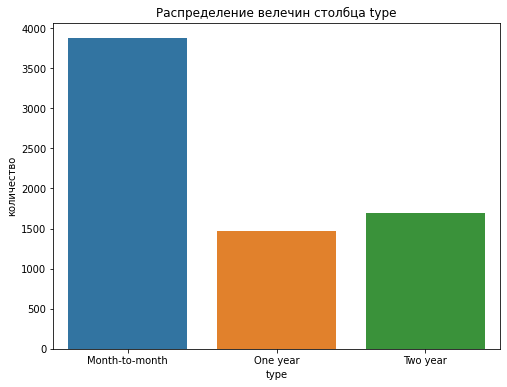

In [26]:
distribution(data_contract, 'type')

In [27]:
data_contract['paperless_billing'].value_counts(normalize=True)

Yes    0.592219
No     0.407781
Name: paperless_billing, dtype: float64

/opt/conda/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


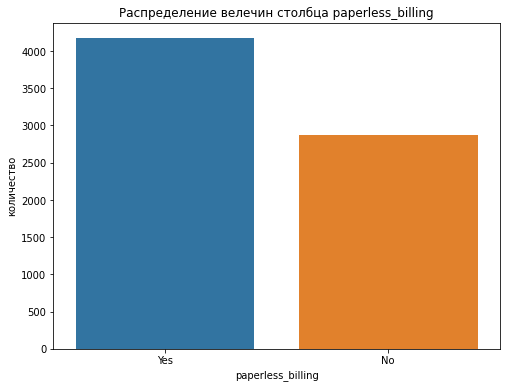

In [28]:
distribution(data_contract, 'paperless_billing')

In [29]:
data_contract['payment_method'].value_counts(normalize=True)

Electronic check             0.335794
Mailed check                 0.228880
Bank transfer (automatic)    0.219225
Credit card (automatic)      0.216101
Name: payment_method, dtype: float64

/opt/conda/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


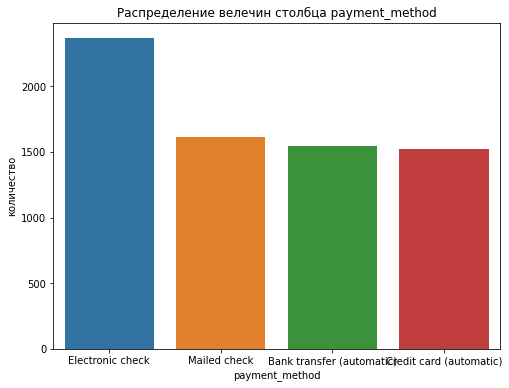

In [30]:
distribution(data_contract, 'payment_method')

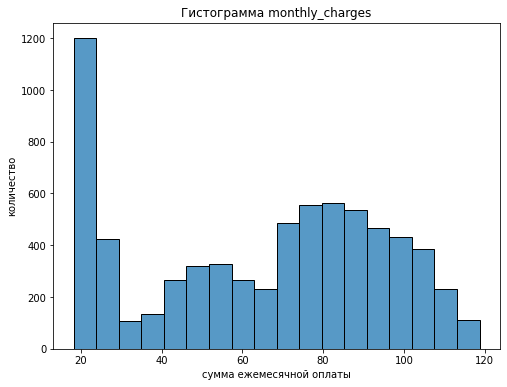

In [31]:
plt.subplots(figsize=(8,6))
sns.histplot(data_contract['monthly_charges'])
plt.title('Гистограмма monthly_charges')
plt.xlabel('сумма ежемесячной оплаты')
plt.ylabel('количество')
plt.show()

In [32]:
data_contract['target'].value_counts(normalize=True)

0    0.843675
1    0.156325
Name: target, dtype: float64

/opt/conda/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


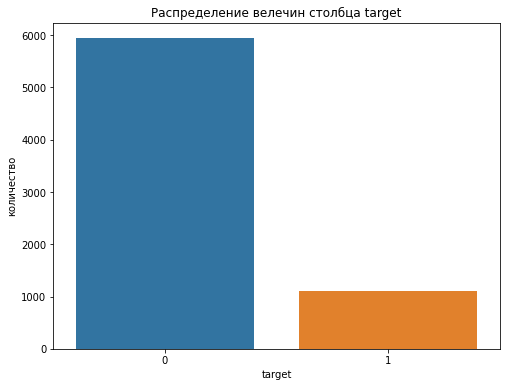

In [33]:
distribution(data_contract, 'target')

Наша целевая переменная распределена неравномерно, меньшое количество клиентов перестают сервис 15% противв 85%.

Избавимся от ненужных признаков: begin_date, end_date, total_charges. Избавляемся от total charges, так как это призкнак можно получить из количества дней пользования сервисом, деленных на 30 и месячных трат.

In [34]:
data_contract = data_contract.drop(['begin_date', 'end_date', 'total_charges'], axis=1)

Проведем предисследовательский анализ второго датафрейма - data_personal

In [35]:
data_personal['senior_citizen'].value_counts(normalize=True)

0    0.837853
1    0.162147
Name: senior_citizen, dtype: float64

/opt/conda/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


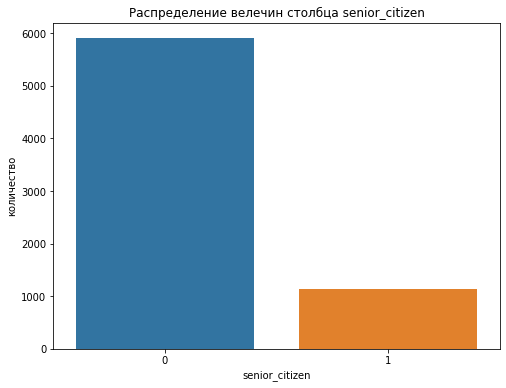

In [36]:
distribution(data_personal, 'senior_citizen')

Поменяем значения столбца senior_citizen с 0 и 1, на yes и no.

In [37]:
def conversion(row):
    if row['senior_citizen'] == 0:
        return 'No'
    else:
        return 'Yes'
data_personal['senior_citizen'] = data_personal.apply(conversion, axis=1)

In [38]:
data_personal['gender'].value_counts(normalize=True)

Male      0.504756
Female    0.495244
Name: gender, dtype: float64

/opt/conda/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


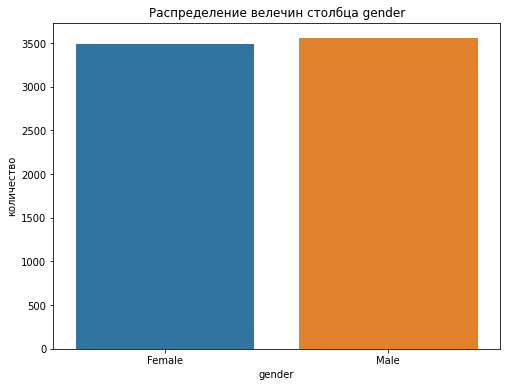

In [39]:
distribution(data_personal, 'gender')

In [40]:
data_personal['partner'].value_counts(normalize=True)

No     0.516967
Yes    0.483033
Name: partner, dtype: float64

/opt/conda/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


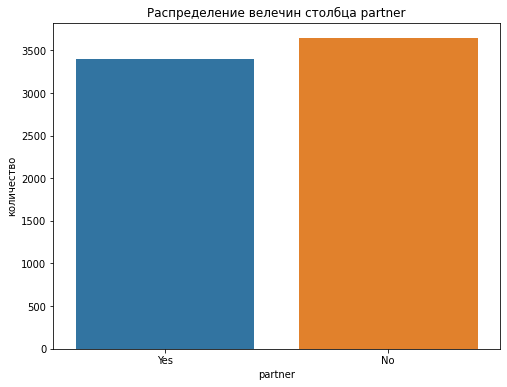

In [41]:
distribution(data_personal, 'partner')

In [42]:
data_personal['dependents'].value_counts(normalize=True)

No     0.700412
Yes    0.299588
Name: dependents, dtype: float64

/opt/conda/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


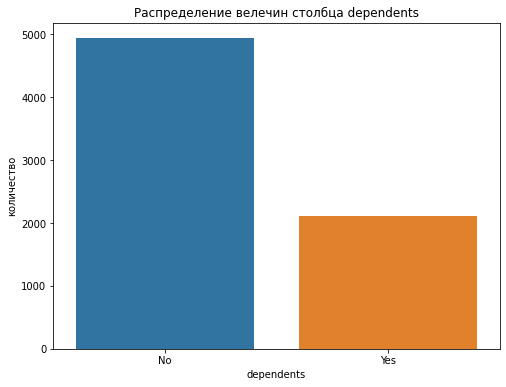

In [43]:
distribution(data_personal, 'dependents')

Равномерно распределены признаки gender и partner, столбцы является ли абонент пенсионером(senior_citizen) и есть ли у абонента дети(dependents) смещены к значению - нет 83%/16% и 70%/30% соответсвенно.

Проведем предисследовательский анализ тертьего датафрейма - data_internet

In [44]:
data_internet['internet_service'].value_counts(normalize=True)

Fiber optic    0.561175
DSL            0.438825
Name: internet_service, dtype: float64

/opt/conda/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


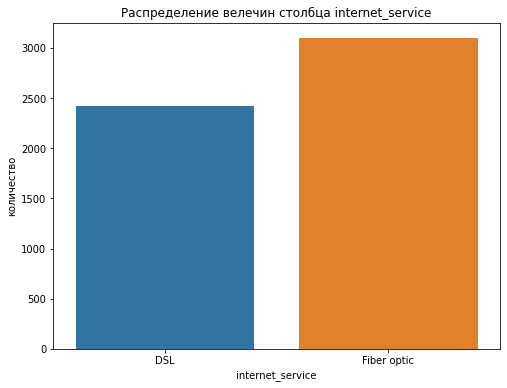

In [45]:
distribution(data_internet, 'internet_service')

In [46]:
data_internet['online_security'].value_counts(normalize=True)

No     0.63404
Yes    0.36596
Name: online_security, dtype: float64

/opt/conda/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


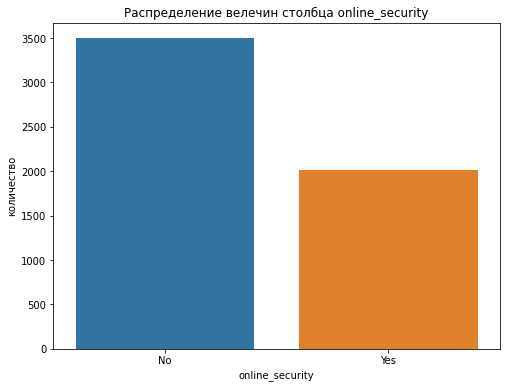

In [47]:
distribution(data_internet, 'online_security')

In [48]:
data_internet['online_backup'].value_counts(normalize=True)

No     0.559724
Yes    0.440276
Name: online_backup, dtype: float64

/opt/conda/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


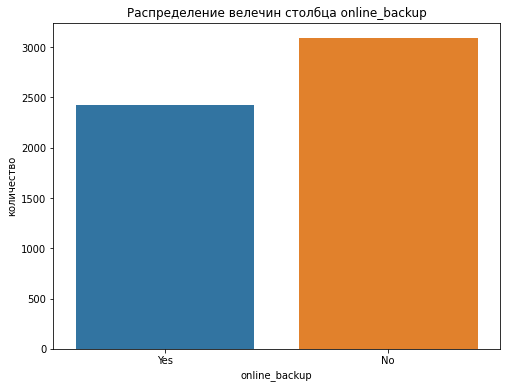

In [49]:
distribution(data_internet, 'online_backup')

In [50]:
data_internet['device_protection'].value_counts(normalize=True)

No     0.560993
Yes    0.439007
Name: device_protection, dtype: float64

/opt/conda/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


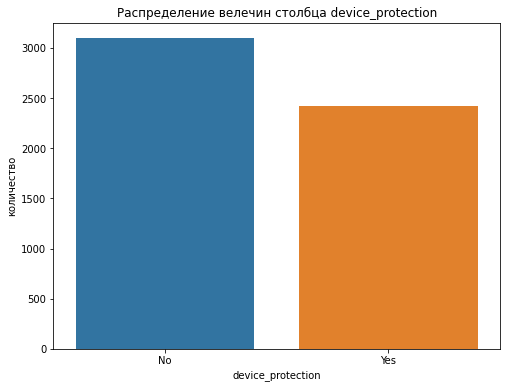

In [51]:
distribution(data_internet, 'device_protection')

In [52]:
data_internet['tech_support'].value_counts(normalize=True)

No     0.629509
Yes    0.370491
Name: tech_support, dtype: float64

/opt/conda/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


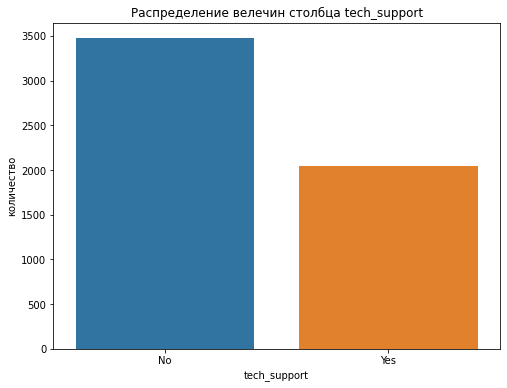

In [53]:
distribution(data_internet, 'tech_support')

In [54]:
data_internet['streaming_t_v'].value_counts(normalize=True)

No     0.509335
Yes    0.490665
Name: streaming_t_v, dtype: float64

/opt/conda/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


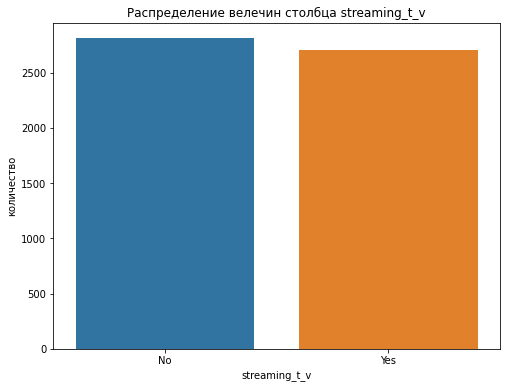

In [55]:
distribution(data_internet, 'streaming_t_v')

In [56]:
data_internet['streaming_movies'].value_counts(normalize=True)

No     0.504803
Yes    0.495197
Name: streaming_movies, dtype: float64

/opt/conda/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


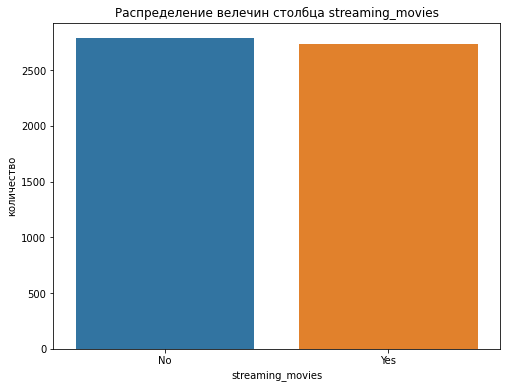

In [57]:
distribution(data_internet, 'streaming_movies')

Равномерно распределены признаки streaming_t_v и streaming_movies, отсальные признаки имеют смещения к одному из велечин.

Рассмотрим четвертый датафрейм - data_phone.

In [58]:
data_phone['multiple_lines'].value_counts(normalize=True)

No     0.532935
Yes    0.467065
Name: multiple_lines, dtype: float64

/opt/conda/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


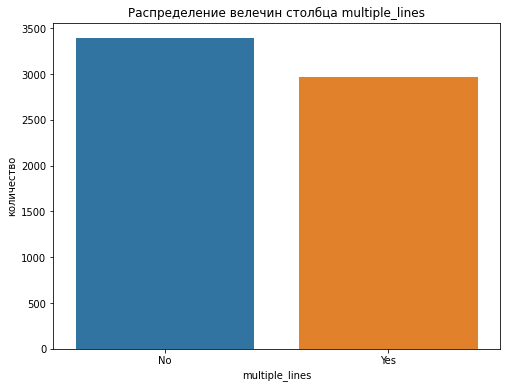

In [59]:
distribution(data_phone, 'multiple_lines')

Распределение признака multiple_lines(подключение телефона к нескольким линиям одновременно) имеет небольшое смещение в сторону - нет 53%/47%.

## Объединение данных

In [60]:
print(f'Размерность data_contract: {data_contract.shape}')
print(f'Размерность data_personal: {data_personal.shape}')
print(f'Размерность data_internet: {data_internet.shape}')
print(f'Размерность data_phone: {data_phone.shape}')

Размерность data_contract: (7043, 8)
Размерность data_personal: (7043, 5)
Размерность data_internet: (5517, 8)
Размерность data_phone: (6361, 2)


Количесво строк в data_contract совпадает с data_personal и id вних также идентичные, поэтому объединим эти два датафрейма методом join, датафреймы data_internet и data_phone объеденим с помощью left join

In [61]:
data = data_personal.join(data_contract.set_index('id'), on='id')
data = data.join(data_internet.set_index('id'), on='id', how='left')
data = data.join(data_phone.set_index('id'), on='id', how='left')

In [62]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 20 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   id                 7043 non-null   object 
 1   gender             7043 non-null   object 
 2   senior_citizen     7043 non-null   object 
 3   partner            7043 non-null   object 
 4   dependents         7043 non-null   object 
 5   type               7043 non-null   object 
 6   paperless_billing  7043 non-null   object 
 7   payment_method     7043 non-null   object 
 8   monthly_charges    7043 non-null   float64
 9   period             7043 non-null   int64  
 10  dutnp              7043 non-null   int64  
 11  target             7043 non-null   int64  
 12  internet_service   5517 non-null   object 
 13  online_security    5517 non-null   object 
 14  online_backup      5517 non-null   object 
 15  device_protection  5517 non-null   object 
 16  tech_support       5517 

In [63]:
data.head()

,id,gender,senior_citizen,partner,dependents,type,paperless_billing,payment_method,monthly_charges,period,dutnp,target,internet_service,online_security,online_backup,device_protection,tech_support,streaming_t_v,streaming_movies,multiple_lines
0,7590-VHVEG,Female,No,Yes,No,Month-to-month,Yes,Electronic check,29.85,31,1,0,DSL,No,Yes,No,No,No,No,NaN
1,5575-GNVDE,Male,No,No,No,One year,No,Mailed check,56.95,1036,304,0,DSL,Yes,No,Yes,No,No,No,No
2,3668-QPYBK,Male,No,No,No,Month-to-month,Yes,Mailed check,53.85,123,3,0,DSL,Yes,Yes,No,No,No,No,No
3,7795-CFOCW,Male,No,No,No,One year,No,Bank transfer (automatic),42.30,1371,273,0,DSL,Yes,No,Yes,Yes,No,No,NaN
4,9237-HQITU,Female,No,No,No,Month-to-month,Yes,Electronic check,70.70,153,3,0,Fiber optic,No,No,No,No,No,No,No


Пропуски, сформировавшиеся в ходе объединения таблиц, можно интерпитировать либо как отсутсвие определенной услуги либо отсутсвие информации об оказании услуги клиенту.

##  Исследовательский анализ и предобработка данных объединённого датафрейма

In [64]:
data.describe(include='all')

,id,gender,senior_citizen,partner,dependents,type,paperless_billing,payment_method,monthly_charges,period,dutnp,target,internet_service,online_security,online_backup,device_protection,tech_support,streaming_t_v,streaming_movies,multiple_lines
count,7043,7043,7043,7043,7043,7043,7043,7043,7043.000000,7043.000000,7043.000000,7043.000000,5517,5517,5517,5517,5517,5517,5517,6361
unique,7043,2,2,2,2,3,2,4,NaN,NaN,NaN,NaN,2,2,2,2,2,2,2,2
top,4369-NYSCF,Male,No,No,No,Month-to-month,Yes,Electronic check,NaN,NaN,NaN,NaN,Fiber optic,No,No,No,No,No,No,No
freq,1,3555,5901,3641,4933,3875,4171,2365,NaN,NaN,NaN,NaN,3096,3498,3088,3095,3473,2810,2785,3390
mean,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,64.761692,898.555729,159.821383,0.156325,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
std,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,30.090047,683.130510,225.318235,0.363189,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
min,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,18.250000,0.000000,0.000000,0.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
25%,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,35.500000,276.000000,6.000000,0.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
50%,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,70.350000,761.000000,18.000000,0.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
75%,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,89.850000,1461.000000,273.000000,0.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


- gender
Уникальные значения: 2 (Male, Female);
Наиболее частое значение: Male (3555 записей, что составляет около 50.5%).
- senior_citizen
Уникальные значения: 2 (Yes, No);
Наиболее частое значение: No (5901 запись, что составляет примерно 83.8%).
- partner
Уникальные значения: 2 (Yes, No);
Наиболее частое значение: No (3641 запись, около 51.7%).
- dependents
Уникальные значения: 2 (Yes, No);
Наиболее частое значение: No (4933 записи, примерно 70%).
- type
Уникальные значения: 3 (Month-to-month, One year, Two year);
Наиболее частое значение: Month-to-month (3875 записей, около 55%).
- paperless_billing
Уникальные значения: 2 (Yes, No);
Наиболее частое значение: Yes (4171 запись, примерно 59.2%).
- payment_method
Уникальные значения: 4 (Electronic check, Mailed check, Bank transfer (automatic), Credit card (automatic));
Наиболее частое значение: Electronic check (2365 записей, около 33.5%).
- monthly_charges
Среднее значение: приблизительно 64.76;
Стандартное отклонение: около 30.09;
Минимальное значение: 18.25;
Максимальное значение: 118.75
- period
Среднее значение: приблизительно 898.56;
Стандартное отклонение: около 683.13;
Минимальное значение: 0;
Максимальное значение: 2314;
- dutnp
Среднее значение: приблизительно 160;
Стандартное отклонение: около 225;
Минимальное значение: 0;
Максимальное значение: 731;
- target
Уникальные значения: 2 (0, 1);
Среднее значение: около 0.16 (что указывает на низкий уровень целевого события).
- internet_service
Уникальные значения: 2 (Fiber optic, DSL);
Наиболее частое значение: Fiber optic.
- online_security
Уникальные значения: 2 (Yes, No);
Наиболее частое значение: No.
- online_backup
Уникальные значения: 2 (Yes, No);
Наиболее частое значение: No.
- device_protection
Уникальные значения: 2 (Yes, No);
Наиболее частое значение: No.
- tech_support
Уникальные значения: 2 (Yes, No);
Наиболее частое значение: No.
- streaming_t_v
Уникальные значения: 2 (Yes, No);
Наиболее частое значение: No.
- streaming_movies
Уникальные значения: 2 (Yes, No);
Наиболее частое значение: No.
- multiple_lines
Уникальные значения: 2 (Yes, No);
Наиболее частое значение: No.

In [65]:
#проверим наличие явных дубликатов
data.duplicated().sum()

0

In [66]:
num_cols = ['period', 'monthly_charges', 'dutnp']
cat_cols = data.select_dtypes(include=['object']).columns.tolist()
cat_cols = cat_cols[1:]
print(cat_cols)

['gender', 'senior_citizen', 'partner', 'dependents', 'type', 'paperless_billing', 'payment_method', 'internet_service', 'online_security', 'online_backup', 'device_protection', 'tech_support', 'streaming_t_v', 'streaming_movies', 'multiple_lines']


<AxesSubplot:title={'center':'Диаграмма рассеяния для количественных признаков monthly_charges и period, разбитых по target'}, xlabel='monthly_charges', ylabel='period'>

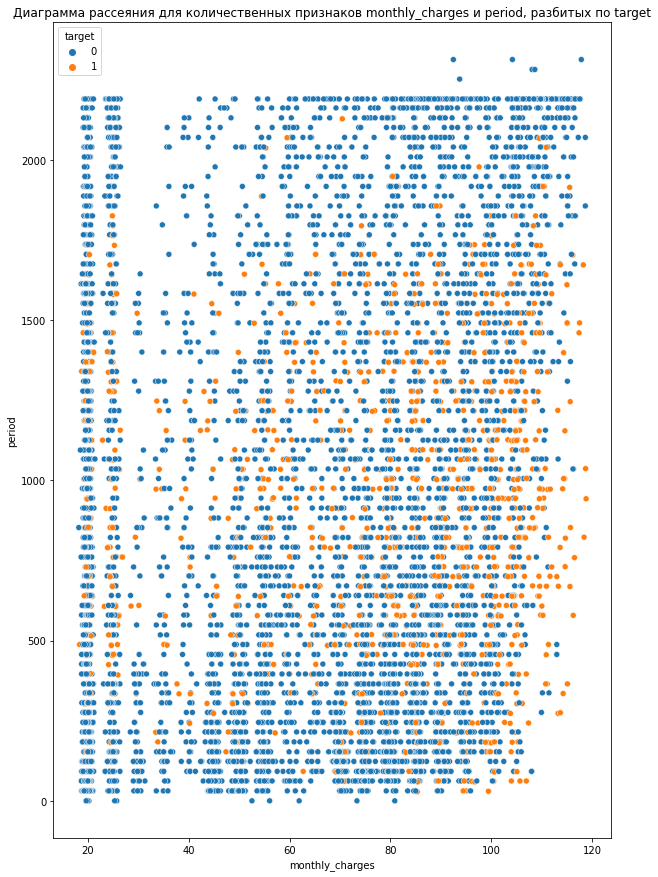

In [67]:
plt.figure(figsize=(10,15))
plt.title('Диаграмма рассеяния для количественных признаков monthly_charges и period, разбитых по target')
sns.scatterplot(data=data, x='monthly_charges', y='period', hue='target')

<AxesSubplot:title={'center':'Диаграмма рассеяния для количественных признаков dutnp и period, разбитых по target'}, xlabel='dutnp', ylabel='period'>

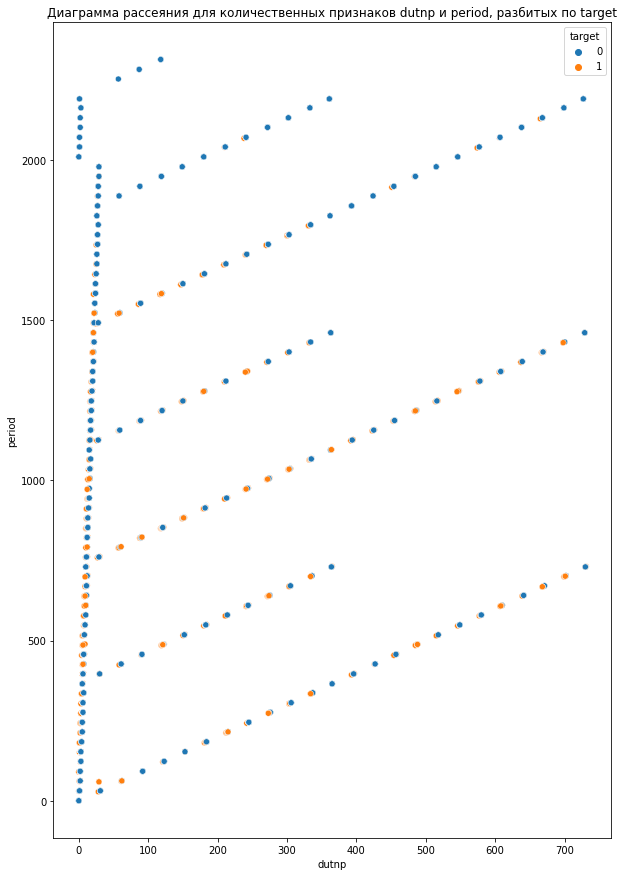

In [68]:
plt.figure(figsize=(10,15))
plt.title('Диаграмма рассеяния для количественных признаков dutnp и period, разбитых по target')
sns.scatterplot(data=data, x='dutnp', y='period', hue='target')

<AxesSubplot:title={'center':'Диаграмма рассеяния для количественных признаков monthly_charges и dutnp, разбитых по target'}, xlabel='monthly_charges', ylabel='dutnp'>

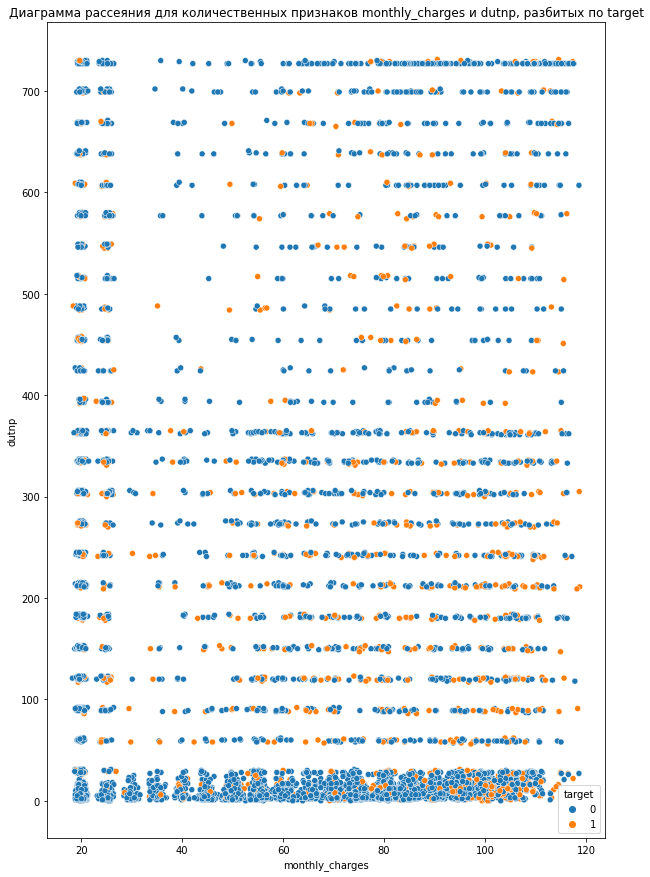

In [69]:
plt.figure(figsize=(10,15))
plt.title('Диаграмма рассеяния для количественных признаков monthly_charges и dutnp, разбитых по target')
sns.scatterplot(data=data, x='monthly_charges', y='dutnp', hue='target')

Заменим пропуски значениями 'No'

In [1]:
data = data.fillna('No')

NameError: name 'data' is not defined

In [ ]:
print(f'Пропусков в data: {data.isnull().sum()}')

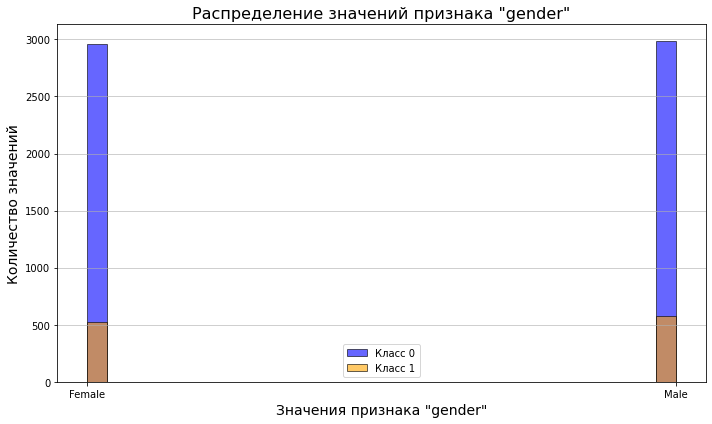

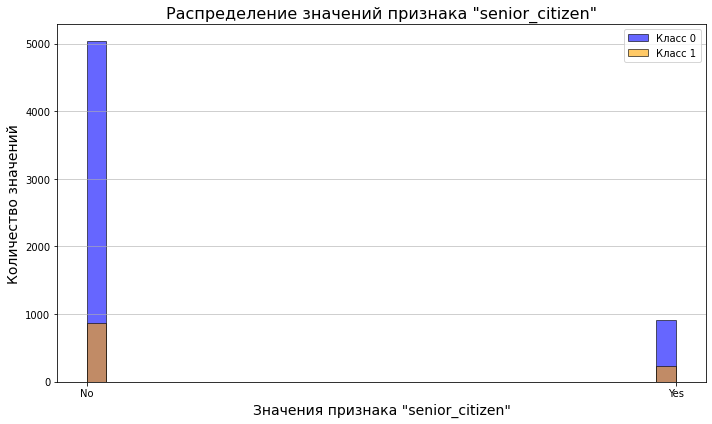

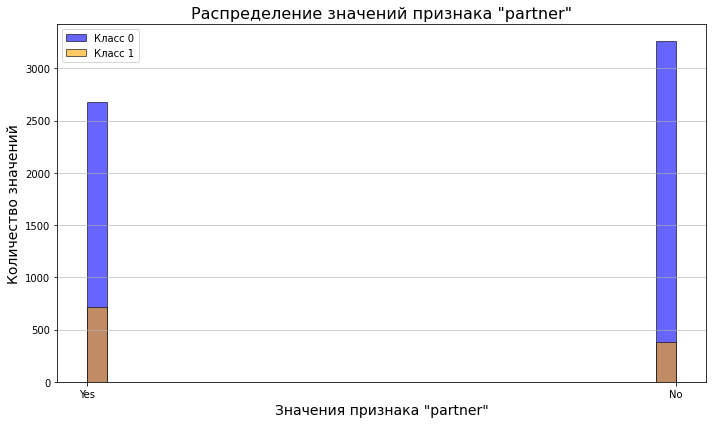

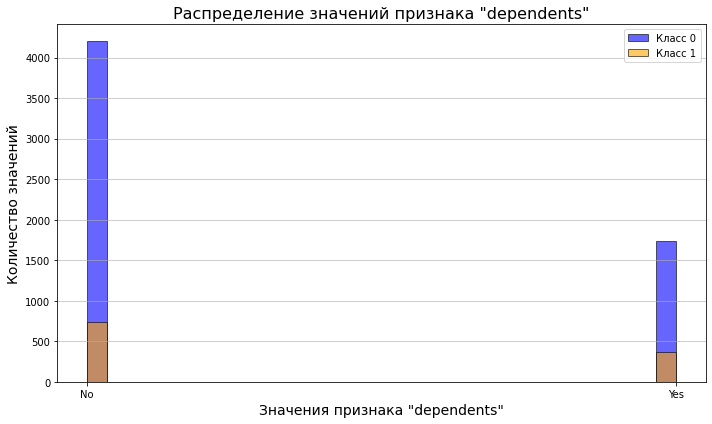

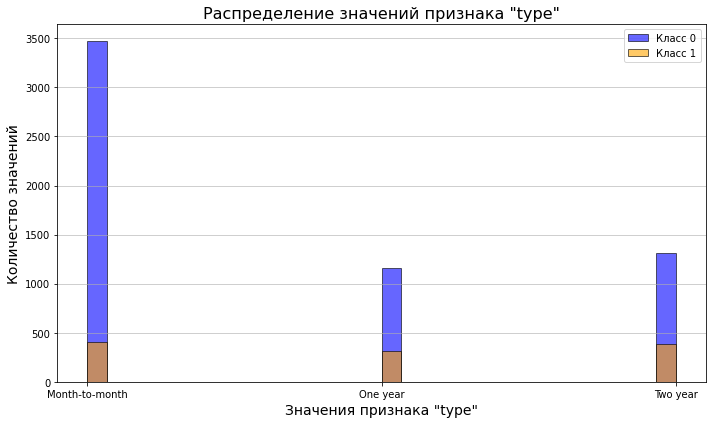

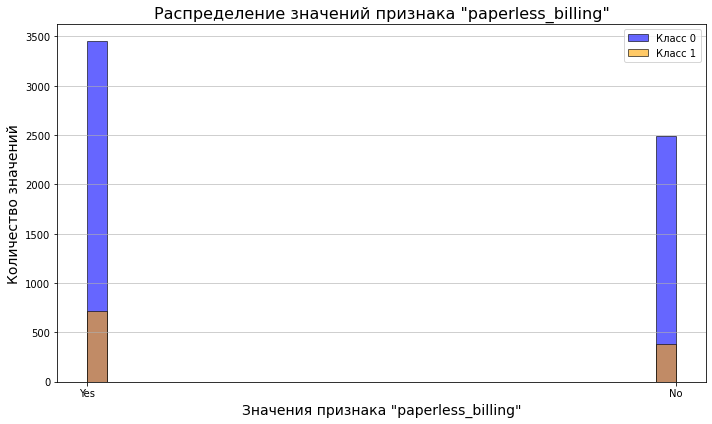

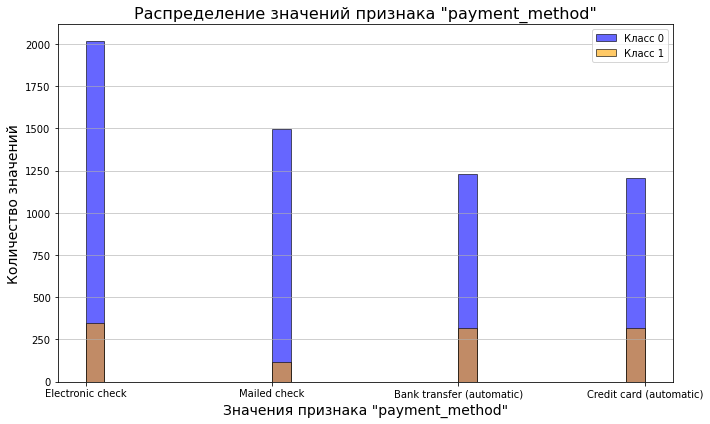

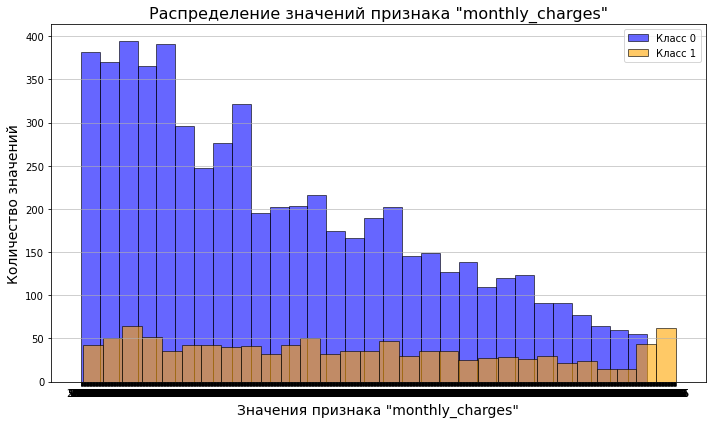

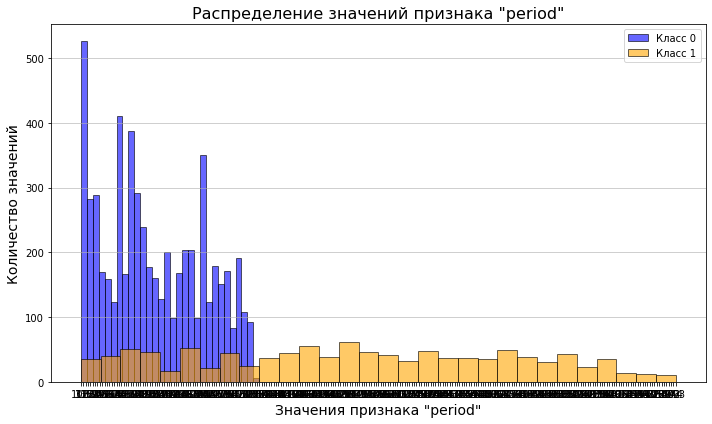

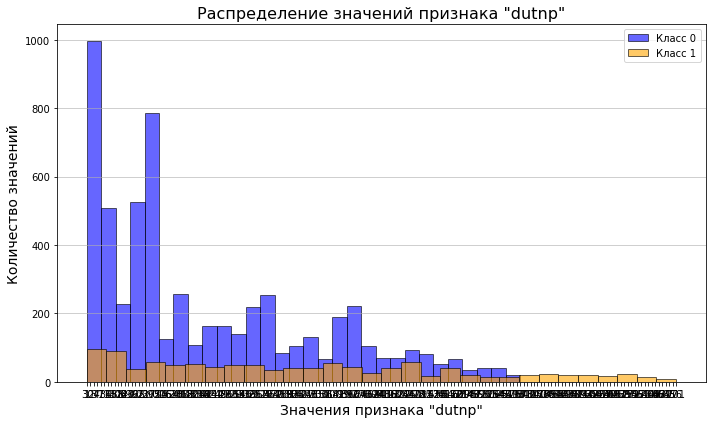

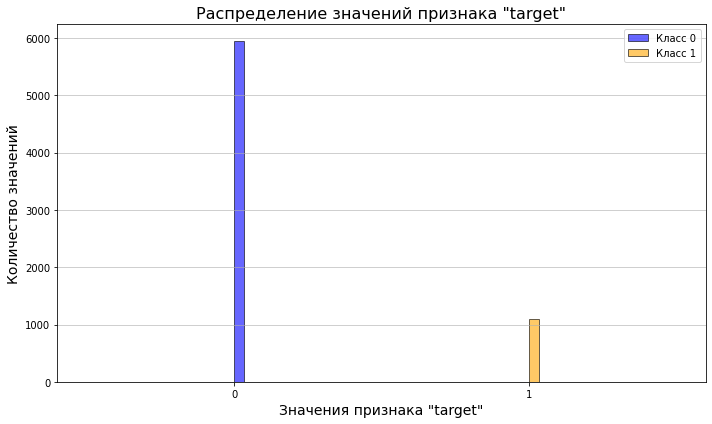

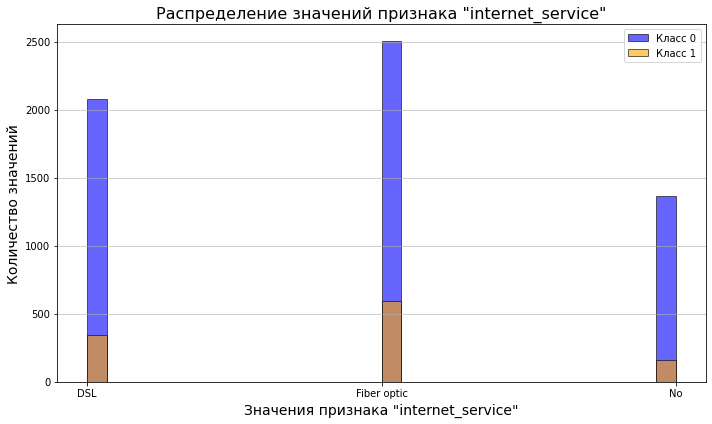

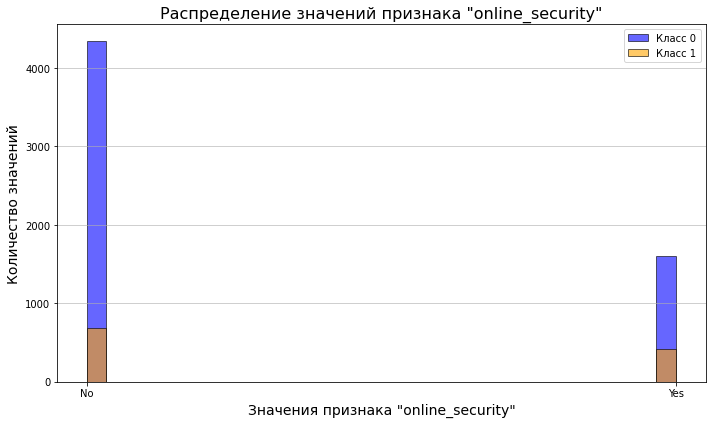

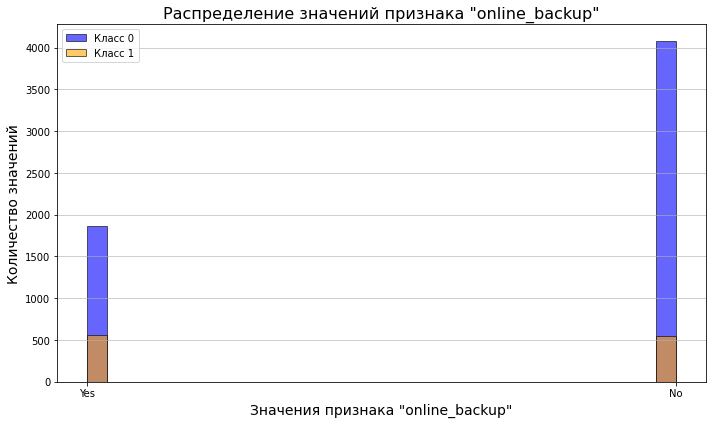

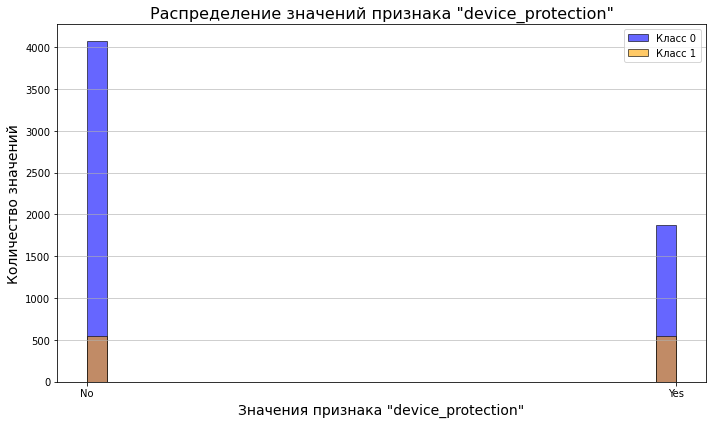

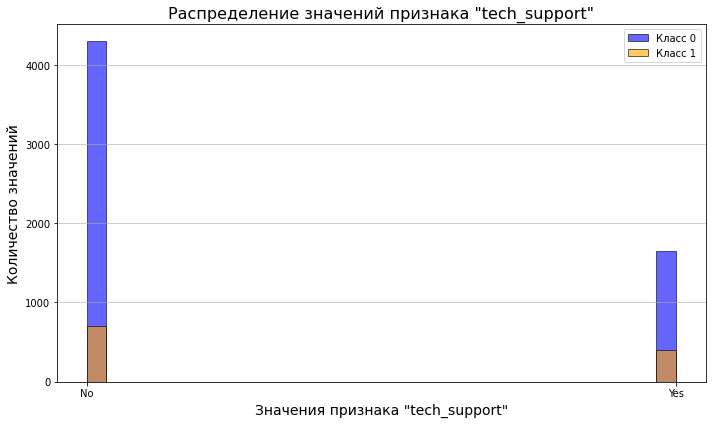

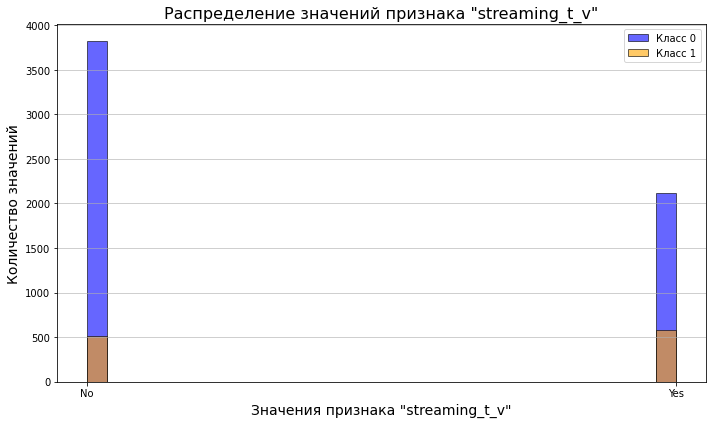

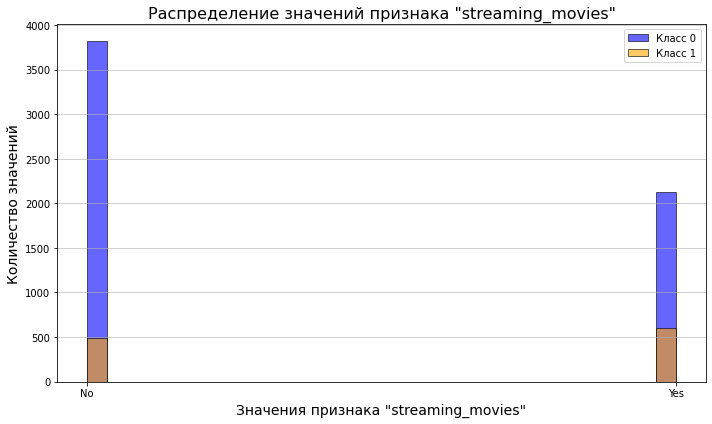

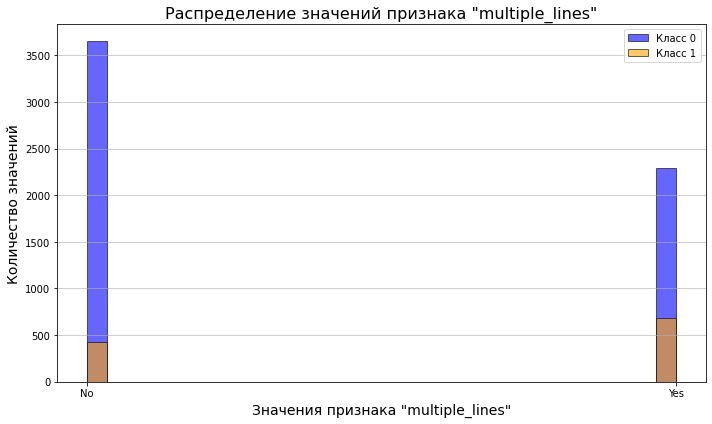

In [72]:
for i in data.columns:
    if i not in ['id']:
        target0 = data.loc[data['target'] == 0, i].astype(str) 
        target1 = data.loc[data['target'] == 1, i].astype(str)  
        
        plt.figure(figsize=(10, 6))

        
        plt.hist(target0, bins=30, alpha=0.6, color='blue', label='Класс 0', edgecolor='black')
        plt.hist(target1, bins=30, alpha=0.6, color='orange', label='Класс 1', edgecolor='black')

        plt.title(f'Распределение значений признака "{i}"', fontsize=16)
        plt.xlabel(f'Значения признака "{i}"', fontsize=14)
        plt.ylabel('Количество значений', fontsize=14)
        plt.grid(axis='y', alpha=0.75)
        plt.legend(frameon=True)
        plt.tight_layout()
        plt.show()

В ходе проведенного анализа можно сделать несколько выводов.
     
Чаще расторгают договоры:    
- Пенсионеры 
- Люди в браке 
- Пользователи с детьми
- Пользователи, которые платят каждый месяц
- Клиенты, которые пользуются любым видом автоплатежей
- Пользователи с блокировкой опасных сайтов, облачным хранилищем файлов или антивирусом
- Клиенты с стриминговым телевидением и каталогами фильмов
- Пользователи с подключением телефона к нескольким линиям одновременно

In [73]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 20 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   id                 7043 non-null   object 
 1   gender             7043 non-null   object 
 2   senior_citizen     7043 non-null   object 
 3   partner            7043 non-null   object 
 4   dependents         7043 non-null   object 
 5   type               7043 non-null   object 
 6   paperless_billing  7043 non-null   object 
 7   payment_method     7043 non-null   object 
 8   monthly_charges    7043 non-null   float64
 9   period             7043 non-null   int64  
 10  dutnp              7043 non-null   int64  
 11  target             7043 non-null   int64  
 12  internet_service   7043 non-null   object 
 13  online_security    7043 non-null   object 
 14  online_backup      7043 non-null   object 
 15  device_protection  7043 non-null   object 
 16  tech_support       7043 

В объединенном датафрейме имеются 15 категориальных и 3 числовых признака. Часть из них не сбалансированы. Категориальные имеют дисбаланс классов, а числовые не не имеют нормального распределения.

Признак target является целевым для обучения. Он бинарный категориальный и не сбалансирован с перевесом в пользу значения 1 (клиент пользуется сервисом). Данный признак не содержит пропусков. Следовательно, по всем объектам выборки есть целевые значения.

Следущим шагом будет проверка признаков на коллинеарность.

,gender,senior_citizen,partner,dependents,type,paperless_billing,payment_method,monthly_charges,period,dutnp,target,internet_service,online_security,online_backup,device_protection,tech_support,streaming_t_v,streaming_movies,multiple_lines
gender,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.009025,0.000000,0.000000,0.008581,0.000000,0.018397,0.009882,0.000000,0.000000,0.000000,0.000000,0.000000
senior_citizen,0.000000,1.000000,0.016992,0.324576,0.086231,0.242133,0.292725,0.304691,0.063315,0.168544,0.086159,0.160702,0.057028,0.102065,0.090686,0.092565,0.163120,0.186141,0.221313
partner,0.000000,0.016992,1.000000,0.652122,0.179736,0.013218,0.243008,0.203237,0.453688,0.373573,0.226688,0.000000,0.221673,0.219223,0.238079,0.185993,0.193258,0.182011,0.220101
dependents,0.000000,0.324576,0.652122,1.000000,0.147680,0.172593,0.224903,0.184213,0.198729,0.294688,0.046871,0.108463,0.124945,0.031533,0.010416,0.096912,0.017331,0.058999,0.033103
type,0.000000,0.086231,0.179736,0.147680,1.000000,0.106860,0.277462,0.388266,0.634155,0.868851,0.094015,0.505187,0.152145,0.098884,0.137610,0.179999,0.066961,0.069608,0.065498
paperless_billing,0.000000,0.242133,0.013218,0.172593,0.106860,1.000000,0.370495,0.467783,0.026799,0.199856,0.083398,0.231438,0.000000,0.196443,0.160796,0.055929,0.343524,0.325551,0.252972
payment_method,0.000000,0.292725,0.243008,0.224903,0.277462,0.370495,1.000000,0.399536,0.350964,0.334796,0.214832,0.323886,0.262911,0.282475,0.306866,0.272101,0.377209,0.378907,0.339313
monthly_charges,0.009025,0.304691,0.203237,0.184213,0.388266,0.467783,0.399536,1.000000,0.387579,0.359637,0.225925,0.918980,0.551631,0.629573,0.667685,0.576217,0.835225,0.833391,0.676233
period,0.000000,0.063315,0.453688,0.198729,0.634155,0.026799,0.350964,0.387579,1.000000,0.812651,0.374569,0.060845,0.395693,0.414982,0.426931,0.404795,0.339313,0.339313,0.398222
dutnp,0.000000,0.168544,0.373573,0.294688,0.868851,0.199856,0.334796,0.359637,0.812651,1.000000,0.241624,0.295734,0.338802,0.235053,0.314424,0.385601,0.174116,0.178033,0.185817


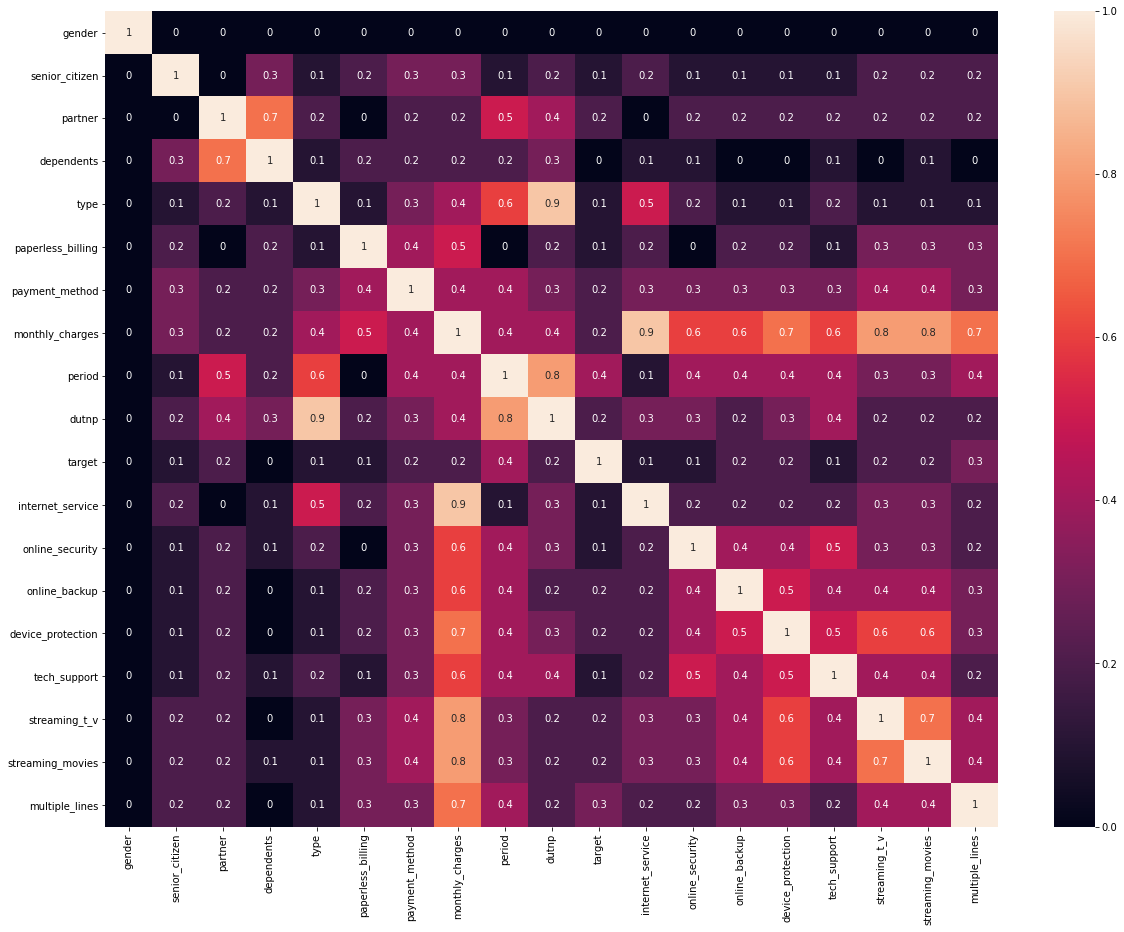

In [74]:
multicollinearity = data.drop('id', axis=1).phik_matrix(interval_cols=num_cols)
display(multicollinearity)

plt.subplots(figsize=(20,15))
sns.heatmap(multicollinearity.copy().round(1), annot=True);

Есть пару признаков которые сильно коррелируют друг с другом - dutnp и type, dutnp и period, monthly charges и internet service.
Это повлияет на линейные модели, но так как обучатся будут более сложные модели, не будем избавлятся от этих признаков.

Признак gender вообще почти не коррилирует ни с одним другим признаком.

Больше всего целевая переменная коррелирует с period, multiple_lines и dutnp

## Подготовка данных

In [75]:
#Сделаем из признака id индексы 
data = data.set_index('id')

In [76]:
X = data.drop('target', axis=1)
y = data['target']

X_train, X_test, y_train, y_test = train_test_split(
    X,
    y,
    test_size = TEST_SIZE,
    random_state = RANDOM_STATE)

print(f'Размер тренировочной выборки: {X_train.shape[0]}')
print(f'Размер тестовой выборки: {X_test.shape[0]}')

Размер тренировочной выборки: 5282
Размер тестовой выборки: 1761


In [77]:
data_preprocessor = ColumnTransformer(
    [
        ('ohe', OneHotEncoder(drop='first', handle_unknown='ignore', sparse_output=False), cat_cols),
        ('num', StandardScaler(), num_cols)
    ], 
    remainder='passthrough'
)

pipe_final = Pipeline([
    ('preprocessor', data_preprocessor),
    ('models', LogisticRegression(random_state=RANDOM_STATE, class_weight='balanced'))
])

## Обучение моделей машинного обучения

In [78]:
param_grid=[

    {
        'models': [DecisionTreeClassifier(random_state=RANDOM_STATE)],
        'models__max_depth': [5, 10, 20, 50, 100],
        'models__max_features': range(2, 12),
        'models__min_samples_split' : range(2, 10),
        'models__min_samples_leaf': range(1, 10),
        'preprocessor__num': [StandardScaler(), MinMaxScaler()]  
    },
    
     
    {
        'models': [KNeighborsClassifier()],
        'models__n_neighbors': range(1, 50),
        'preprocessor__num': [StandardScaler(), MinMaxScaler()]
    },

    
    {
        'models': [LogisticRegression(
            random_state=RANDOM_STATE,
            class_weight='balanced',
            solver='liblinear', 
            penalty='l1'
        )],
        'models__C': range(1, 5),
        'preprocessor__num': [StandardScaler(), MinMaxScaler()]  
    },
    
    {
        'models': [SVC(random_state=RANDOM_STATE)],
        'models__kernel': ['linear', 'rbf'],
        'preprocessor__num': [StandardScaler(), MinMaxScaler()]
    }
]

search = RandomizedSearchCV(
    pipe_final,
    param_grid,
    cv=4,
    scoring='roc_auc',
    random_state=RANDOM_STATE,
    n_jobs=-1
)


search.fit(X_train, y_train)

print('Лучшая модель и её параметры:\n\n', search.best_estimator_)
print ('Метрика лучшей модели:', search.best_score_)

Лучшая модель и её параметры:

 Pipeline(steps=[('preprocessor',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('ohe',
                                                  OneHotEncoder(drop='first',
                                                                handle_unknown='ignore',
                                                                sparse_output=False),
                                                  ['gender', 'senior_citizen',
                                                   'partner', 'dependents',
                                                   'type', 'paperless_billing',
                                                   'payment_method',
                                                   'internet_service',
                                                   'online_security',
                                                   'online_backup',
                                                   '

In [79]:
search.cv_results_

{'mean_fit_time': array([0.02850223, 0.0292657 , 0.03152812, 0.02914238, 0.02752727,
        0.03239119, 0.0351125 , 0.03224736, 0.0284248 , 0.02740419]),
 'std_fit_time': array([0.00089707, 0.00031548, 0.00044055, 0.00046176, 0.00032198,
        0.00119789, 0.00476587, 0.00060401, 0.00040261, 0.00065772]),
 'mean_score_time': array([0.01112199, 0.01131994, 0.01140612, 0.01129615, 0.01113224,
        0.01159495, 0.0119074 , 0.01155037, 0.01084471, 0.01111639]),
 'std_score_time': array([1.23061061e-04, 3.26353208e-04, 3.50091213e-04, 9.66188902e-05,
        3.21015057e-04, 3.93002035e-04, 8.34261671e-04, 5.66594577e-04,
        8.00127921e-05, 3.32092583e-04]),
 'param_preprocessor__num': masked_array(data=[MinMaxScaler(), MinMaxScaler(), MinMaxScaler(),
                    MinMaxScaler(), MinMaxScaler(), MinMaxScaler(),
                    StandardScaler(), StandardScaler(), StandardScaler(),
                    StandardScaler()],
              mask=[False, False, False, False, False,

Были обучены простые модели с подбором гиперпараметров: логистическая регрессия, деревья решений, ближайших соседей и метод опорных векторов. Лучшую метрику - 0.76 показала DecisionTreeClassifier с нормировкой количественных признаков StandardScaler и гиперпараметрами - max_depth=5, max_features=10, min_samples_leaf=6, min_samples_split=8.

Метрика лучшей модели достигает порога(0.85), поэтому попробуем обучить более сложные модели.

In [80]:
pipe_final_CBC = Pipeline([
    ('preprocessor', data_preprocessor),
    ('models', CatBoostClassifier(
        iterations=250,
        verbose=50,
        learning_rate=0.1,
        depth=6
    ))
])

In [81]:
param_grid_CBC = {
    'models__iterations': [100, 250, 500],
    'models__learning_rate': [0.01, 0.05, 0.1],
    'models__depth': [4, 6, 8],
    'models__l2_leaf_reg': [1, 3, 5],
    'models__bagging_temperature': [0, 0.5, 1],
}
search_CBC = RandomizedSearchCV(pipe_final_CBC,
                                 param_grid_CBC,
                                 scoring='roc_auc',
                                 cv=4,
                                 verbose=2,
                                 random_state=RANDOM_STATE,
                                 n_jobs=-1)

search_CBC.fit(X_train, y_train)

best_params = search_CBC.best_params_
best_score = search_CBC.best_score_
best_index = search_CBC.best_index_
best_fit_time = search_CBC.cv_results_['mean_fit_time'][best_index]

print('Лучшие параметры:', best_params)
print('Лучший roc_auc на CV:', best_score)
print('Время обучения лучшей модели (в секундах):', best_fit_time)

Fitting 4 folds for each of 10 candidates, totalling 40 fits
0:	learn: 0.6845993	total: 48.6ms	remaining: 24.2s
50:	learn: 0.4474793	total: 148ms	remaining: 1.3s
100:	learn: 0.3704374	total: 241ms	remaining: 952ms
150:	learn: 0.3381915	total: 337ms	remaining: 779ms
200:	learn: 0.3212872	total: 432ms	remaining: 643ms
250:	learn: 0.3100793	total: 533ms	remaining: 529ms
300:	learn: 0.3009121	total: 629ms	remaining: 416ms
350:	learn: 0.2936099	total: 730ms	remaining: 310ms
400:	learn: 0.2870825	total: 823ms	remaining: 203ms
450:	learn: 0.2812038	total: 923ms	remaining: 100ms
499:	learn: 0.2755224	total: 1.03s	remaining: 0us
[CV] END models__bagging_temperature=0, models__depth=6, models__iterations=500, models__l2_leaf_reg=3, models__learning_rate=0.01; total time=   1.6s
0:	learn: 0.6847211	total: 2.13ms	remaining: 1.06s
50:	learn: 0.4511723	total: 93.7ms	remaining: 825ms
100:	learn: 0.3763967	total: 185ms	remaining: 732ms
150:	learn: 0.3428608	total: 291ms	remaining: 673ms
200:	learn: 0.

Была обучена модель градиентного бустинга CatBoostClassifier с подбором гиперпараметров. Лучшую метрику на кроссвалидации - 0.899 показала модель с гиперпараметрами - learning_rate = 0.05, l2_leaf_reg=5, iterations=500, depth=6, bagging_temperature=1. Время обучения лучшей модели ~2c.

## Выбор лучшей модели

В качестве лучшей модели возьмем CatBoostClassifier. Проверим качество модели на тесте.

In [82]:
predict_proba = search_CBC.predict_proba(X_test)
print(f'ROC_AUC на тестовых данных: {(roc_auc_score(y_test, predict_proba[:, 1])):.2f}')

ROC_AUC на тестовых данных: 0.92


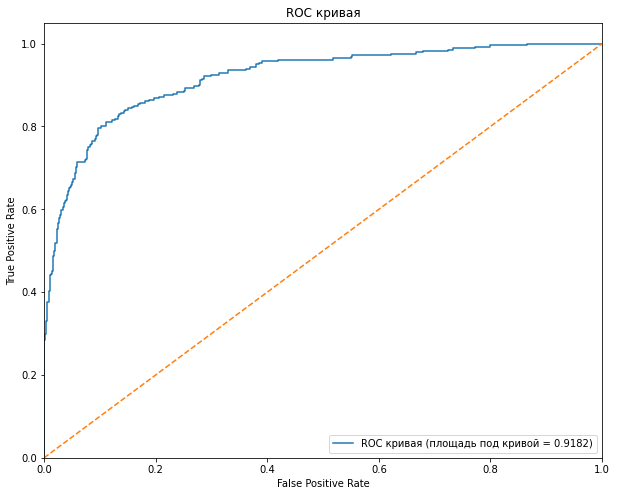

In [83]:
# ROC кривая
fpr, tpr, treshold = roc_curve(y_test, predict_proba[:, 1])
roc_auc = auc(fpr, tpr)

plt.subplots(figsize=(10,8))
plt.plot(
    fpr,
    tpr, 
    label='ROC кривая (площадь под кривой = %0.4f)' % roc_auc
)
plt.plot([0, 1], [0, 1], linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC кривая')
plt.legend(loc="lower right")
plt.show()

Метрика на тестовых данных получилась - 0.92, что выше порога 0.85

Проведем анализ важности признаков

In [84]:
best_model = search_CBC.best_estimator_.named_steps['models']
feature_importances = best_model.get_feature_importance()
feature_names = search_CBC.best_estimator_.named_steps['preprocessor'].get_feature_names_out()

importance_df = pd.DataFrame({
    'Feature': feature_names,
    'Importance': feature_importances
})

importance_df = importance_df.sort_values(by='Importance', ascending=False)
importance_df

,Feature,Importance
19,num__period,36.539394
21,num__dutnp,20.976376
20,num__monthly_charges,8.410862
2,ohe__partner_Yes,4.187770
18,ohe__multiple_lines_Yes,3.462939
9,ohe__payment_method_Mailed check,3.054406
13,ohe__online_backup_Yes,2.850594
5,ohe__type_Two year,2.682633
17,ohe__streaming_movies_Yes,2.069617
14,ohe__device_protection_Yes,1.904336


В ходе анализа важности признаков было выявлено:
- самыми важными признаками для модели стали сгенирированные признаки period и days_until_the_next_payment(dutnp)
- самым важным признаком, из тех, что не были сгенерированы стал monthly_charges
- самыми неважными оказались признаки с пропущенными значениями, замененными на заглушку

## Общий вывод и рекомендации заказчику

В ходе выполнения проекта была создана модель для прогноза оттока клиентов. Основной метрикой эффективности модели была выбрана ROC_AUC, которая должна быть не ниже 0.85.

Для решения задачи были выполнены следующие шаги:
- Загрузка и предварительная обработка данных: данные были загружены и выполнен их первичный осмотр, был выполнен исследовательский анализ каждого датафрейма, были сформированы новые признаки и удалены ненужные.
- Объединение данных: были объединены все датафреймы один датафрейм по id.
- Исследовательский анализ и предобработка данных объединённого датафрейма: был выполнен исследовательский анализ объединённого датафрейма, были визуализированы распределения признаков и проведен корреляционный анализ.
- Подготовка данных: данные были разбиты на тренировочную и тестовую выборки в соотношении 75%/25%, был создан пайплайн для кодирования категориальных и стандартизации количественных признаков.
- Обучение моделей машинного обучения: в качестве простых моделей были выбраны логистическая регрессия, деревья решений, ближайших соседей и метод опорных векторов, был выполнен подбор гиперпараметров, по итогам кроссвалидации лучшей простой моделью стал DecisionTreeClassifier с метрикой ROC_AUC=0.76. В качестве сложной модели был выбран градиентный бустинг CatBoostClassifier, были подобраны оптимальные гиперпараметры и получена метрика ROC_AUC=0.9 на кроссвалидации.
- Выбор лучшей модели и тестирование на тестовой выборке: лучшей моделью была выбрана CatBoostClassifier, которая на тестовой выборке показала метрику ROC_AUC=0.92, что удовлетворяет порогу 0.85. Был проводен анализ важности признаков, самыми важными стали сгенирированные period и days_until_the_next_payment(dutnp).

Рекомендации для бизнеса: исходя из полученных результатов, можно сделать вывод о важности признаков - время пользования услугами и временем до следущей оплаты, они сильно влияют на результат, следовательно имеет смысл следить за этими признаками.
В качестве альтернативного задания можно кластеризовать клиентов, и выявить важные признаки, которые влияют на отток для каждого кластера.